# 프로젝트 - Movielens 영화 SBR

In [479]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [480]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [481]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

In [482]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    # Convert 'Time' to datetime
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    return data

In [483]:
 def create_sessions(data, session_timeout=10):
    """
    Create sessions based on UserID and RefinedTime with second-level granularity.
    Args:
        data (pd.DataFrame): Input data containing UserID and Time or RefinedTime.
        session_timeout (int): Timeout in seconds to split sessions.
    Returns:
        pd.DataFrame: Data with new SessionID column.
    """
    # Ensure 'RefinedTime' is available for finer granularity
    if 'RefinedTime' not in data.columns:
        refined_time_delta = pd.to_timedelta(np.random.rand(len(data)), unit='s')
        if len(refined_time_delta) != len(data):
            raise ValueError("Length mismatch when adding refined time.")
        data['RefinedTime'] = data['Time'] + refined_time_delta

    # Calculate time difference in seconds
    time_diff = data.groupby('UserId')['RefinedTime'].diff().dt.total_seconds()
    if len(time_diff) != len(data):
        raise ValueError("Length mismatch in time difference calculation.")
    data['TimeDiff'] = time_diff

    # Assign SessionID based on timeout in seconds
    data['SessionID'] = (data['TimeDiff'] > session_timeout).cumsum()

    # Reset SessionID per UserID
    data['SessionID'] = data.groupby('UserId')['SessionID'].transform(lambda x: x - x.min() + 1)

    # Drop temporary column
    data.drop(columns=['TimeDiff'], inplace=True)

    return data


In [484]:
def filter_by_rating(data, threshold=3):
    """
    Filter data based on the Rating threshold.
    Args:
        data (pd.DataFrame): Input data containing Rating column.
        threshold (int): Minimum rating to keep.
    Returns:
        pd.DataFrame: Filtered data with ratings >= threshold.
    """
    return data[data['Rating'] >= threshold]

In [485]:
 def create_sessions(data, session_timeout=10):
    """
    Create sessions based on UserID and RefinedTime with second-level granularity.
    Args:
        data (pd.DataFrame): Input data containing UserID and Time or RefinedTime.
        session_timeout (int): Timeout in seconds to split sessions.
    Returns:
        pd.DataFrame: Data with new SessionID column.
    """
    # Ensure 'RefinedTime' is available for finer granularity
    if 'RefinedTime' not in data.columns:
        data['RefinedTime'] = data['Time'] + pd.to_timedelta(np.random.rand(len(data)), unit='s')

    # Calculate time difference in seconds
    data['TimeDiff'] = data.groupby('UserId')['RefinedTime'].diff().dt.total_seconds()

    # Assign SessionID based on timeout in seconds
    data['SessionID'] = (data['TimeDiff'] > session_timeout).cumsum()

    # Reset SessionID per UserID
    data['SessionID'] = data.groupby('UserId')['SessionID'].transform(lambda x: x - x.min() + 1)

    # Drop temporary column
    data.drop(columns=['TimeDiff'], inplace=True)

    return data


In [486]:
data = load_data(train_path, None)
data = filter_by_rating(data, threshold=1)  # Filter out low ratings
data.sort_values(['UserId', 'Time'], inplace=True)  # Sort data by UserID and Time
data = create_sessions(data)

data

,UserId,ItemId,Rating,Time,RefinedTime,SessionID
31,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00:19.748169263,1
22,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00:55.402561734,2
27,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00:55.994364518,2
37,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00:55.922185159,2
24,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:01:43.191131099,3
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,2001-08-10 14:40:29.992477829,162
999988,6040,1921,4,2001-08-10 14:41:04,2001-08-10 14:41:04.179231911,163
1000172,6040,1784,3,2001-08-10 14:41:04,2001-08-10 14:41:04.985384839,163
1000167,6040,161,3,2001-08-10 14:41:26,2001-08-10 14:41:26.912466568,164


In [487]:
print("\nUnique values per column:")
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")


Unique values per column:
UserId: 6040 unique values
ItemId: 3706 unique values
Rating: 5 unique values
Time: 458455 unique values
RefinedTime: 1000209 unique values
SessionID: 867 unique values


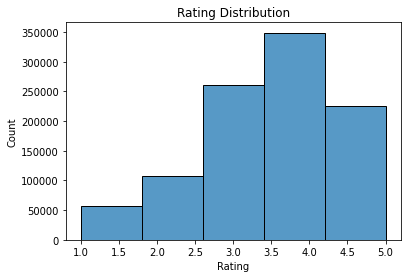

In [488]:
import seaborn as sns
sns.histplot(data['Rating'], bins=5, kde=False)
plt.title('Rating Distribution')
plt.show()

In [489]:
session_lengths = data.groupby('SessionID').size()
print("\nSession Length Analysis:")
print(session_lengths.describe())


Session Length Analysis:
count      867.000000
mean      1153.643599
std       2612.997976
min          1.000000
25%          8.000000
50%         74.000000
75%        839.000000
max      15050.000000
dtype: float64


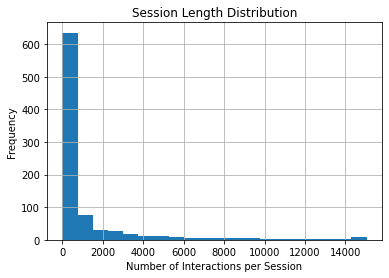

In [490]:
session_lengths.hist(bins=20)
plt.title("Session Length Distribution")
plt.xlabel("Number of Interactions per Session")
plt.ylabel("Frequency")
plt.show()

In [491]:
print("\nShort sessions (<= 2 interactions):")
print(session_lengths[session_lengths <= 2])


Short sessions (<= 2 interactions):
SessionID
708    2
709    2
710    2
711    2
712    2
      ..
863    1
864    1
865    1
866    1
867    1
Length: 113, dtype: int64


In [492]:
print(session_lengths.describe())

count      867.000000
mean      1153.643599
std       2612.997976
min          1.000000
25%          8.000000
50%         74.000000
75%        839.000000
max      15050.000000
dtype: float64


In [493]:
print(type(data))


<class 'pandas.core.frame.DataFrame'>


In [494]:
import pandas as pd

# 딕셔너리를 DataFrame으로 변환
data = pd.DataFrame(data)


In [495]:
session_times = data.groupby('SessionID')['Time'].apply(lambda x: (x.max() - x.min()).total_seconds() / 60)
print("\nSession Time Analysis:")
print(session_times.describe())


Session Time Analysis:
count    8.670000e+02
mean     1.055026e+06
std      5.243510e+05
min      0.000000e+00
25%      4.701909e+05
50%      1.316953e+06
75%      1.469809e+06
max      1.493892e+06
Name: Time, dtype: float64


In [496]:
def clean_data(data):
    """
    Clean the dataset by removing anomalies based on session time and session length.
    Args:
        data (pd.DataFrame): Input dataset.
    Returns:
        pd.DataFrame: Cleaned dataset.
    """
    # 세션 길이 계산
    session_lengths = data.groupby('SessionID').size()
    
    # 세션 시간 계산
    session_times = data.groupby('SessionID')['Time'].apply(lambda x: (x.max() - x.min()).total_seconds())
    
    # 유효한 세션 조건
    valid_lengths = session_lengths[(session_lengths > 1) & (session_lengths < 100)].index  # 길이 조건 완화
    valid_times = session_times[(session_times >= 0) & (session_times <= 12 * 60 * 60)].index  # 세션 시간 범위 확장
    valid_sessions = valid_lengths.intersection(valid_times)
    
    # 유효한 세션만 남기기
    data = data[data['SessionID'].isin(valid_sessions)]
    
    # 데이터 비어있는지 확인
    if data.empty:
        print("Warning: Filtered data is empty. Adjust conditions or check input data.")
    
    return data

# 클리닝 후 데이터 확인
data = clean_data(data)

# 필터링된 데이터 상태 확인
if not data.empty:
    filtered_session_times = data.groupby('SessionID')['Time'].apply(lambda x: (x.max() - x.min()).total_seconds())
    print(filtered_session_times.describe())
else:
    print("Filtered dataset is empty. No valid sessions found.")
 


Filtered dataset is empty. No valid sessions found.


In [497]:
# 열 이름 확인
print(data.columns)


Index(['UserId', 'ItemId', 'Rating', 'Time', 'RefinedTime', 'SessionID'], dtype='object')


In [498]:
print("\nDataset Summary:")
print(f"Number of Sessions: {data['SessionID'].nunique()}")
print(f"Number of Users: {data['UserId'].nunique()}")
print(f"Number of Items: {data['ItemId'].nunique()}")
print(data.head())


Dataset Summary:
Number of Sessions: 0
Number of Users: 0
Number of Items: 0
Empty DataFrame
Columns: [UserId, ItemId, Rating, Time, RefinedTime, SessionID]
Index: []


In [499]:
print(df['UserID'].unique())  # UserID의 고유 값 확인
print(df['UserID'].nunique())  # UserID의 고유 개수 확인


[1]
1


In [500]:
# 세션 길이와 세션 시간 분포 확인
session_lengths = data.groupby('SessionID').size()
session_times = data.groupby('SessionID')['Time'].apply(lambda x: (x.max() - x.min()).total_seconds())

print("\nSession Lengths:")
print(session_lengths.describe())

print("\nSession Times:")
print(session_times.describe())



Session Lengths:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

Session Times:
count       0
unique      0
top       NaN
freq      NaN
Name: Time, dtype: object


In [501]:
# 데이터셋 요약 정보
print(data.info())
print(data.head())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   UserId       0 non-null      int32         
 1   ItemId       0 non-null      int32         
 2   Rating       0 non-null      int32         
 3   Time         0 non-null      datetime64[ns]
 4   RefinedTime  0 non-null      datetime64[ns]
 5   SessionID    0 non-null      int64         
dtypes: datetime64[ns](2), int32(3), int64(1)
memory usage: 0.0 bytes
None
Empty DataFrame
Columns: [UserId, ItemId, Rating, Time, RefinedTime, SessionID]
Index: []


결과 회고

결론적으로 말하자면 '유효한 세션 조건'을 매우 다양한 수치로 조정했지만 충족하지 못했고 'UserId'가 하나인 이유를 찾지 못했다. 여러 시도 끝에 알 수 없는 이유로 모두 결측치로 나오면서 전처리에 실패했다. 데이터 손상이나 경로가 의심되지만 일정 관계로 작업을 중단해야 한다.